In [65]:
import sys
sys.path.append("..")

from model import DaCluDeK

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

In [3]:
defined_keywords = {}
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20, dimensionality_reduction_n_components=2)
doc2vec_model.load_embeddings_model()

# Embeddings

In [57]:
def plot_embeddings_2d(documents_df):
    documents = documents_df['document'].tolist()

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Embeddings 2D', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.03, 1.03, 1.07])

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20, dimensionality_reduction_n_components=2)
    doc2vec_model.load_embeddings_model()

    doc2vec_embeddings = doc2vec_model.encode_documents(documents)
    doc2vec_embeddings_df = pd.DataFrame(doc2vec_embeddings, columns=['x', 'y'])
    doc2vec_embeddings_df['Class'] = documents_df['class_name']

    sns.scatterplot(x='x', y='y', hue='Class', data=doc2vec_embeddings_df, ax=ax[0])
    # for class_name in doc2vec_embeddings_df['class_name'].unique():
    #     sns.kdeplot(x='x', y='y', data=doc2vec_embeddings_df[doc2vec_embeddings_df['class_name'] == class_name], ax=ax[0], levels=5, fill=True, alpha=0.5)
    ax[0].set_title('Doc2Vec', fontsize=16, fontweight='bold')

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=defined_keywords, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True, dimensionality_reduction_model_name='PCA', dimensionality_reduction_n_components=2)
    sentence_transformer_model.load_embeddings_model()

    sentence_transformer_embeddings = sentence_transformer_model.encode_documents(documents)
    sentence_transformer_embeddings_df = pd.DataFrame(sentence_transformer_embeddings, columns=['x', 'y'])
    sentence_transformer_embeddings_df['Class'] = documents_df['class_name']

    sns.scatterplot(x='x', y='y', hue='Class', data=sentence_transformer_embeddings_df, ax=ax[1])
    # for class_name in sentence_transformer_embeddings_df['class_name'].unique():
    #     sns.kdeplot(x='x', y='y', data=sentence_transformer_embeddings_df[sentence_transformer_embeddings_df['class_name'] == class_name], ax=ax[1], levels=5, fill=True, alpha=0.5)
    ax[1].set_title('SentenceTransformer', fontsize=16, fontweight='bold')

    fig.savefig('../../figures/dacludek/embeddings_2d.png')

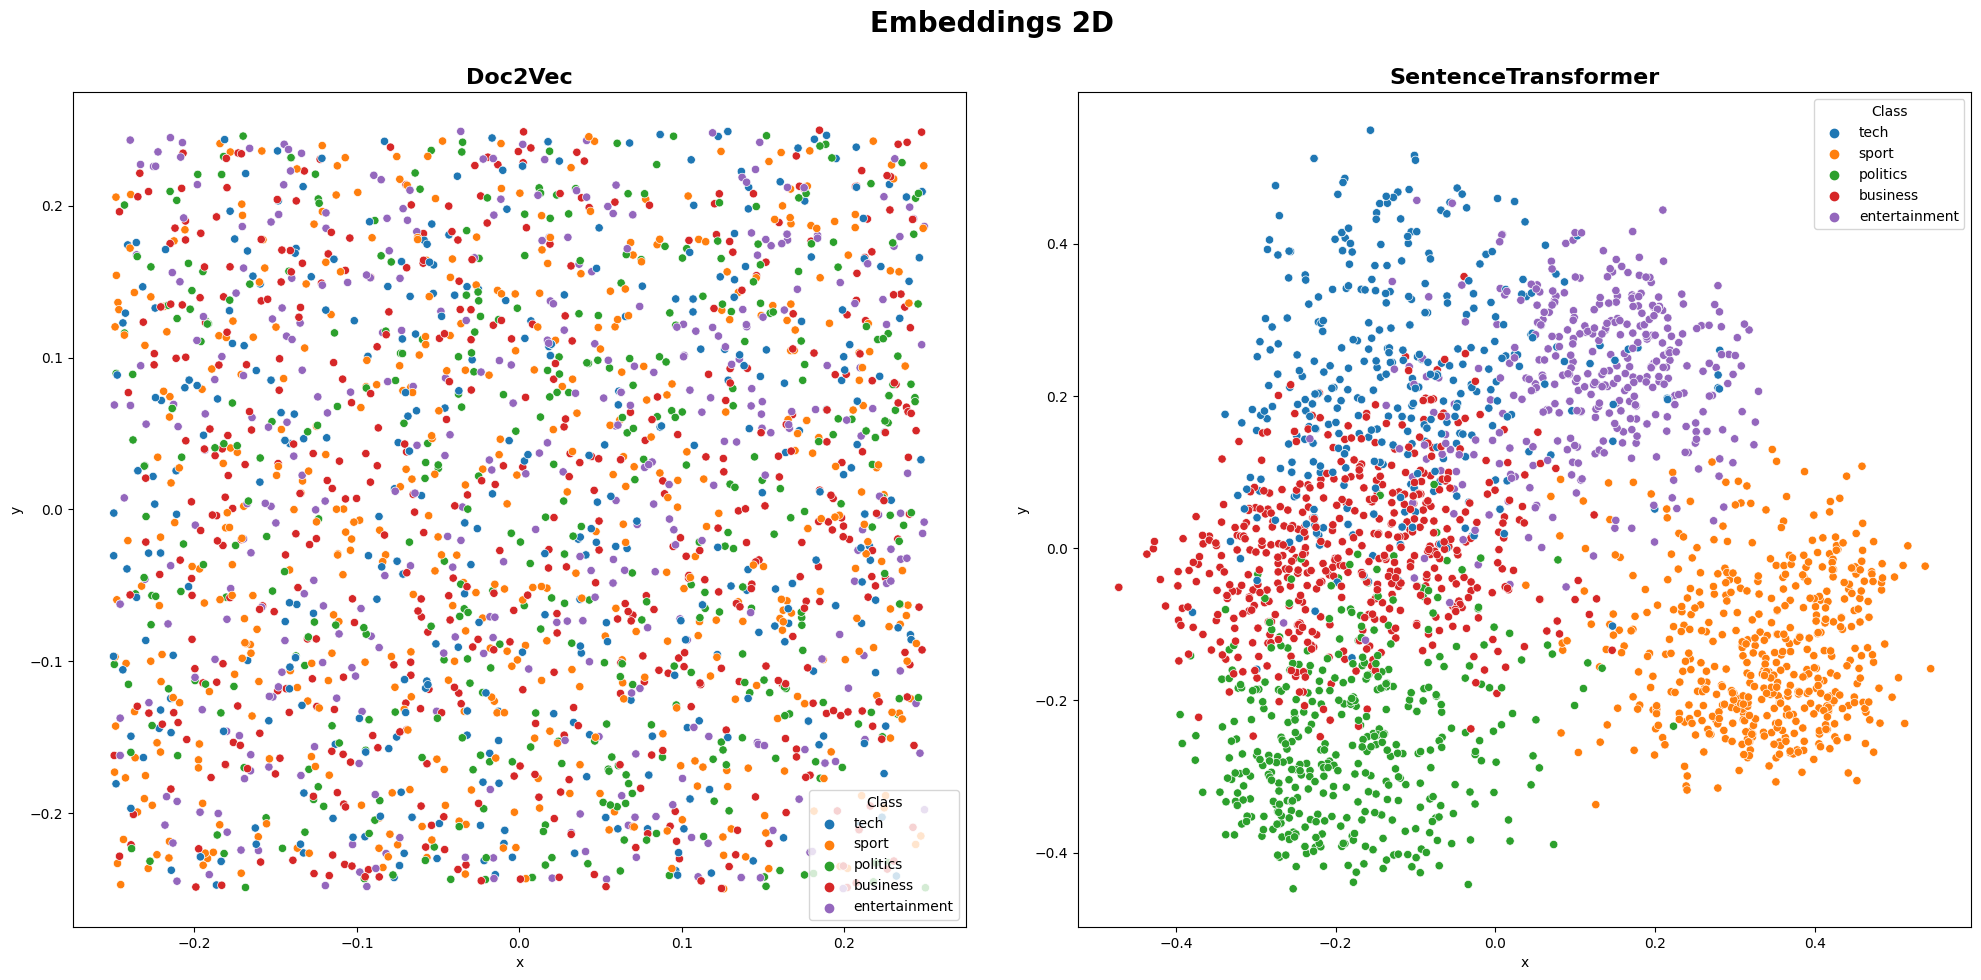

In [58]:
plot_embeddings_2d(documents_df)

# Performances using most frequent words

In [84]:
documents_df = pd.read_csv('../../datasets/data/BBC_News/documents.csv')
documents = documents_df['document'].tolist()
labels = documents_df['class_name'].tolist()

def get_n_most_frequent_keywords_by_class(n: int):
    most_frequent_keywords = {}
    for class_name in documents_df['class_name'].unique():
        count_words_by_class = {}
        for words in documents_df[documents_df['class_name'] == class_name]['document']:
            for word in words.split():
                if word not in count_words_by_class:
                    count_words_by_class[word] = 0
                count_words_by_class[word] += 1

        most_frequent_keywords[class_name] = []
        for word, count in sorted(count_words_by_class.items(), key=lambda item: item[1], reverse=True)[:20]:
            most_frequent_keywords[class_name].append(word)

    for class_name in most_frequent_keywords.keys():
        most_frequent_keywords[class_name] = most_frequent_keywords[class_name][:n]

    return most_frequent_keywords

most_frequent_keywords = get_n_most_frequent_keywords_by_class(10)

In [85]:
most_frequent_keywords['politics']

['government',
 'election',
 'party',
 'labour',
 'plan',
 'tory',
 'minister',
 'public',
 'issue',
 'leader']

In [88]:
def plot_performances_models(documents_df):
    train_docs = documents_df[documents_df['dataset_type'] == 'train']['document'].tolist()
    test_docs = documents_df[documents_df['dataset_type'] == 'test']['document'].tolist()

    train_labels = documents_df[documents_df['dataset_type'] == 'train']['class_name'].tolist()
    test_labels = documents_df[documents_df['dataset_type'] == 'test']['class_name'].tolist()

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    fig.suptitle('Performances (with most frequent keywords)', fontsize=20, fontweight='bold')
    fig.tight_layout(pad=5.0, rect=[-0.01, -0.03, 1.03, 1.07])

    # -- Doc2Vec
    doc2vec_model = DaCluDeK(defined_keywords=most_frequent_keywords, train_documents=documents, embedding_model_name='Doc2Vec', verbose=True, save_cache=True, load_cache=True, doc2vec_n_spacy_keywords=20)
    doc2vec_model.fit()

    y_pred_train = doc2vec_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = doc2vec_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    result_df = pd.DataFrame({'Class': documents_df['class_name'].unique(), 'Train': f1_train, 'Test': f1_test})
    result_df = result_df.melt('Class', var_name='Dataset', value_name='F1 Score')

    sns.barplot(x='Class', y='F1 Score', hue='Dataset', data=result_df, ax=ax[0])

    avg_train, avg_test = np.mean(f1_train), np.mean(f1_test)

    ax[0].set_title('Doc2Vec (Train: {:.2f} - Test: {:.2f})'.format(avg_train, avg_test), fontsize=16, fontweight='bold')
    ax[0].set_ylim(0, 1)

    # -- SentenceTransformer
    sentence_transformer_model = DaCluDeK(defined_keywords=most_frequent_keywords, train_documents=documents, embedding_model_name='SentenceTransformer', verbose=True)
    sentence_transformer_model.fit()

    y_pred_train = sentence_transformer_model.predict(train_docs)['class_name'].tolist()
    y_pred_test = sentence_transformer_model.predict(test_docs)['class_name'].tolist()

    f1_train = f1_score(train_labels, y_pred_train, average=None)
    f1_test = f1_score(test_labels, y_pred_test, average=None)

    result_df = pd.DataFrame({'Class': documents_df['class_name'].unique(), 'Train': f1_train, 'Test': f1_test})
    result_df = result_df.melt('Class', var_name='Dataset', value_name='F1 Score')

    sns.barplot(x='Class', y='F1 Score', hue='Dataset', data=result_df, ax=ax[1])

    avg_train, avg_test = np.mean(f1_train), np.mean(f1_test)

    ax[1].set_title('SentenceTransformer (Train: {:.2f} - Test: {:.2f})'.format(avg_train, avg_test), fontsize=16, fontweight='bold')
    ax[1].set_ylim(0, 1)

    fig.savefig('../../figures/dacludek/performances_with_most_frequent_keywords.png')

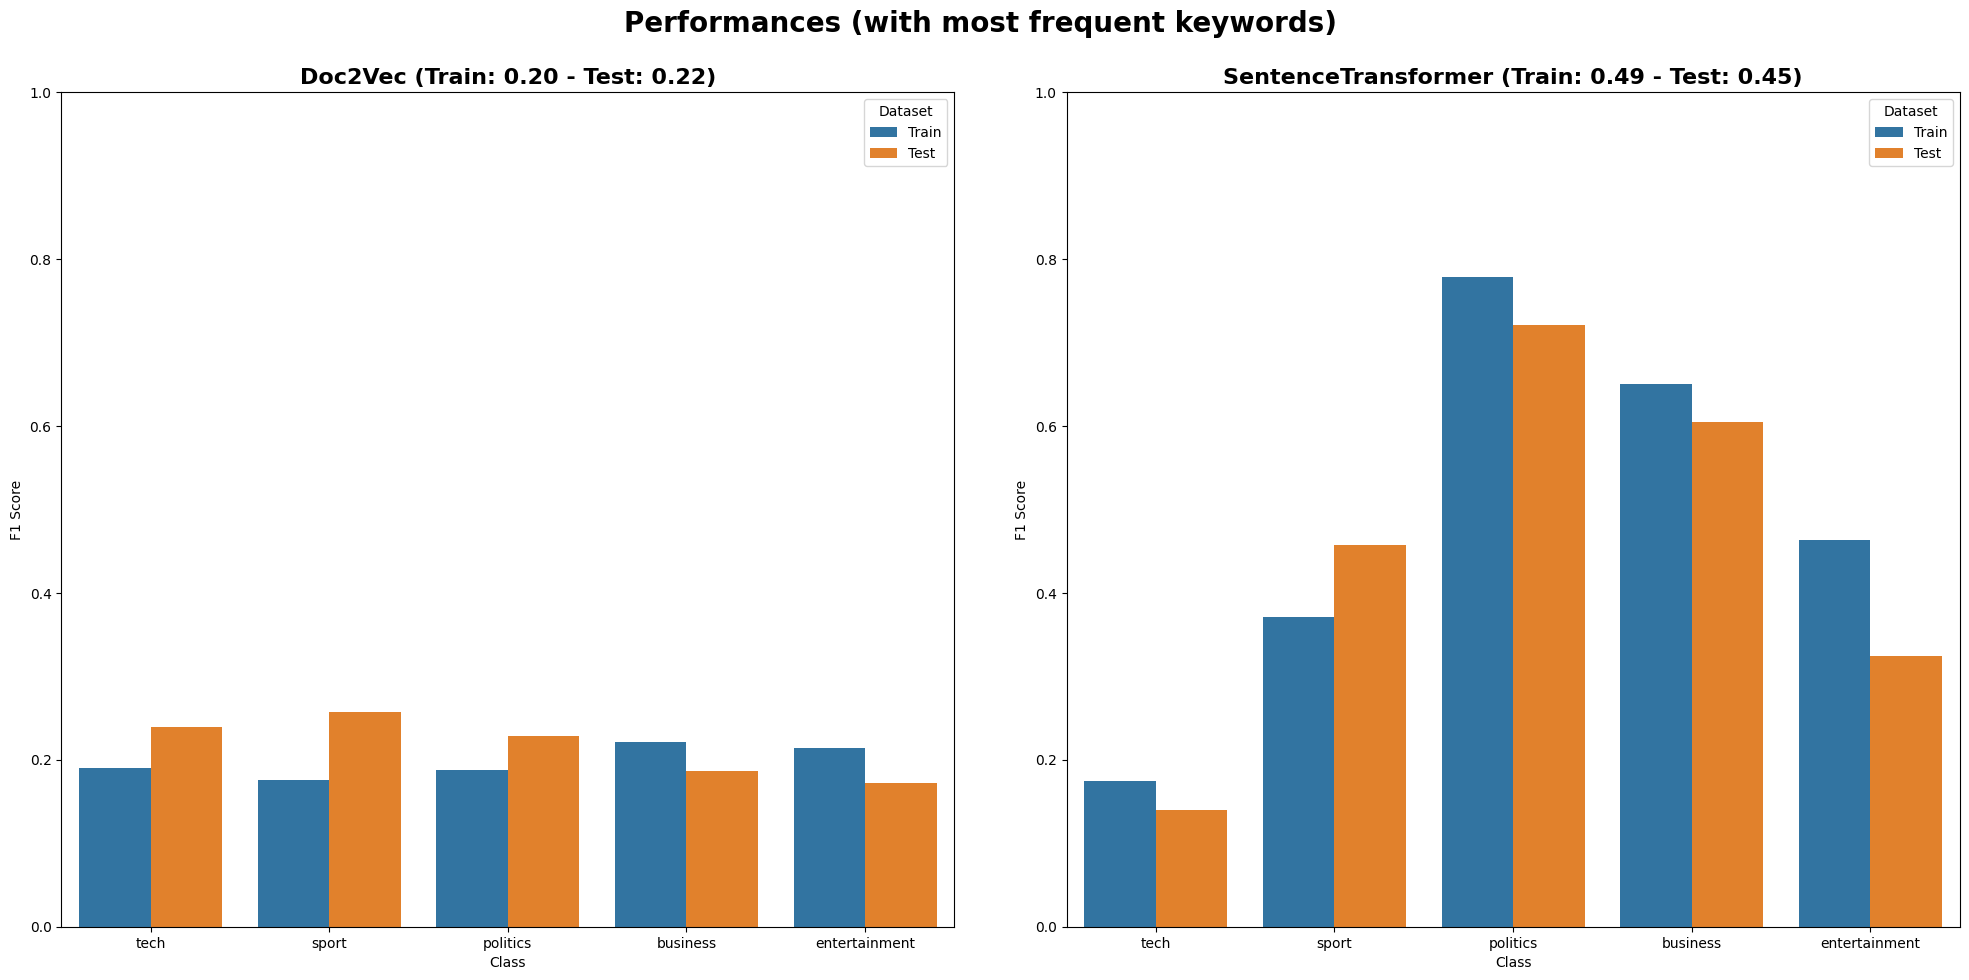

In [89]:
plot_performances_models(documents_df)